In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 30.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
from keras.models import load_model
model = load_model('/content/cnn_20_epochs.h5')

In [ ]:
# Importing required modules

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.layers as L
from tensorflow.keras.datasets import mnist, cifar10

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
# Utility functions
def print_shapes(x_train, x_test, y_train, y_test):
  print(f"x_train: {x_train.shape}\n"\
      f"x_test: {x_test.shape}\n"\
      f"y_train: {y_train.shape}\n"\
      f"y_test: {y_test.shape}\n")

In [ ]:
# loading the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print_shapes(x_train, x_test, y_train, y_test)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)



In [ ]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, height, width, channels))
x_test = x_test.reshape((-1, height, width, channels))

y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, nb_classes)

print_shapes(x_train, x_test, y_train, y_test)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 10)
y_test: (10000, 10)



### Fast Gradient Signed Method (FGSM) attack to generate noise.

In [ ]:
# Function to calculate adversary noise
def generate_adversary(image, label, epsilon=0.1):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)
  perturbation = epsilon * sign_grad  # Apply epsilon to the sign gradient

  return perturbation

  # return sign_grad

In [ ]:
height, width, channels = 32, 32, 3

Prediction from CNN: dog


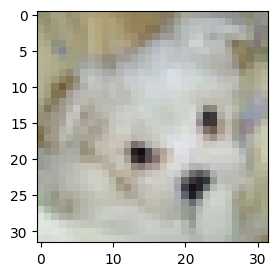

In [ ]:
# Selecting random image for testing
rand_idx = randint(0,49999)
image = X_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

print(f'Prediction from CNN: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [ ]:
# Adding the adversary noise to image
perturbations = generate_adversary(image,label,0.2).numpy()
adversarial = image + (perturbations * 0.05)

1/1 [==============================] - 0s 59ms/step
Original Image Prediction: dog
1/1 [==============================] - 0s 96ms/step
Adversary Prediction: frog


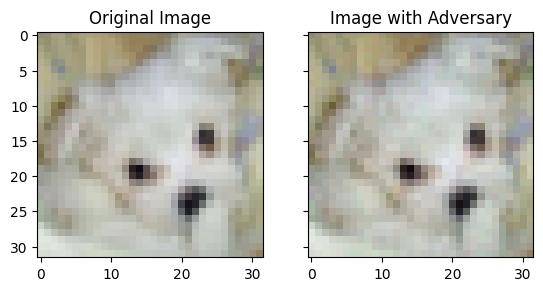

In [ ]:
from art.estimators.classification import KerasClassifier
# Comparing both images
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
print(f'Original Image Prediction: {label_names[model.predict(image).argmax()]}')
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
# Comparing predictions
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 30ms/step
Normal Image Prediction: dog
1/1 [==============================] - 0s 26ms/step
Adversary Prediction: frog


In [ ]:
# Function to generate batch of images with adversary
def adversary_generator(batch_size):
  while True:
    images = []
    labels = []
    for batch in range(batch_size):
      N = randint(0, 49999)
      label = y_train[N]
      image = x_train[N].reshape((1,height, width, channels))

      perturbations = generate_adversary(image, label,0.2).numpy()
      adversarial = image + (perturbations * 0.2)

      images.append(adversarial)
      labels.append(label)

      if batch%1000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size, height, width, channels))
    labels = np.asarray(labels)

    yield images, labels

In [ ]:
# Testing model accuracy on adversarial examples
x_adversarial, y_adversarial = next(adversary_generator(10000))
ad_acc = model.evaluate(x_adversarial, y_adversarial, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")

0 images generated
1000 images generated
2000 images generated
3000 images generated
4000 images generated
5000 images generated
6000 images generated
7000 images generated
8000 images generated
9000 images generated
Accuracy on Adversarial Examples: 5.550000071525574


In [ ]:
import h5py
with h5py.File('adversarial_data_cnn.h5', 'w') as f:
    f.create_dataset('x_adversarial', data=x_adversarial)
    f.create_dataset('y_adversarial', data=y_adversarial)

### For VGG Dropout Data Augmentation model

In [ ]:
from keras.models import load_model
model = load_model('/content/VGG_dropout_augm_batch.h5')

In [ ]:
# Function to calculate adversary noise
def generate_adversary(image, label, epsilon=0.1):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)
  perturbation = epsilon * sign_grad  # Apply epsilon to the sign gradient

  return perturbation

  # return sign_grad

Prediction from VGG_droppout_augm_batch: truck


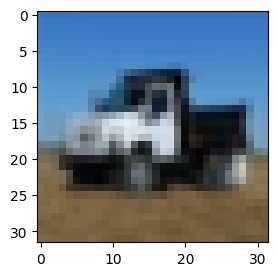

In [ ]:
# Selecting random image for testing
rand_idx = randint(0,49999)
image = X_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

print(f'Prediction from VGG_droppout_augm_batch: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [ ]:
# Adding the adversary noise to image
perturbations = generate_adversary(image,label,0.2).numpy()
adversarial = image + (perturbations * 0.05)

1/1 [==============================] - 0s 23ms/step
Original Image Prediction: truck
1/1 [==============================] - 0s 26ms/step


Adversary Prediction: automobile


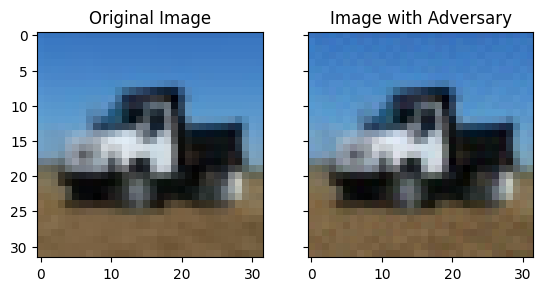

In [ ]:
from art.estimators.classification import KerasClassifier
# Comparing both images
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
print(f'Original Image Prediction: {label_names[model.predict(image).argmax()]}')
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
# Comparing predictions
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 36ms/step
Normal Image Prediction: truck
1/1 [==============================] - 0s 96ms/step
Adversary Prediction: automobile


In [ ]:
# Function to generate batch of images with adversary
def adversary_generator(batch_size):
  while True:
    images = []
    labels = []
    for batch in range(batch_size):
      N = randint(0, 49999)
      label = y_train[N]
      image = x_train[N].reshape((1,height, width, channels))

      perturbations = generate_adversary(image, label,0.2).numpy()
      adversarial = image + (perturbations * 0.2)

      images.append(adversarial)
      labels.append(label)

      if batch%1000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size, height, width, channels))
    labels = np.asarray(labels)

    yield images, labels

In [ ]:
# Testing model accuracy on adversarial examples
x_adversarial, y_adversarial = next(adversary_generator(10000))
ad_acc = model.evaluate(x_adversarial, y_adversarial, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")

0 images generated
1000 images generated
2000 images generated
3000 images generated
4000 images generated
5000 images generated
6000 images generated
7000 images generated
8000 images generated
9000 images generated
Accuracy on Adversarial Examples: 4.919999837875366


In [ ]:
import h5py
with h5py.File('adversarial_data_vgg_augm.h5', 'w') as f:
    f.create_dataset('x_adversarial', data=x_adversarial)
    f.create_dataset('y_adversarial', data=y_adversarial)

### For VGG Dropout Batch Normalization Model

In [ ]:
from keras.models import load_model
model = load_model('/content/VGG_dropout.h5')

In [ ]:
# Function to calculate adversary noise
def generate_adversary(image, label, epsilon=0.1):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)
  perturbation = epsilon * sign_grad  # Apply epsilon to the sign gradient

  return perturbation

  # return sign_grad

Prediction from VGG_droppout_augm_batch: airplane


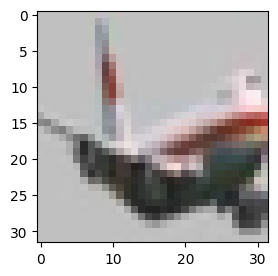

In [ ]:
# Selecting random image for testing
rand_idx = randint(0,49999)
image = X_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

print(f'Prediction from VGG_droppout_augm_batch: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

In [ ]:
# Adding the adversary noise to image
perturbations = generate_adversary(image,label,0.2).numpy()
adversarial = image + (perturbations * 0.05)

1/1 [==============================] - 0s 25ms/step
Original Image Prediction: airplane
1/1 [==============================] - 0s 23ms/step
Adversary Prediction: ship


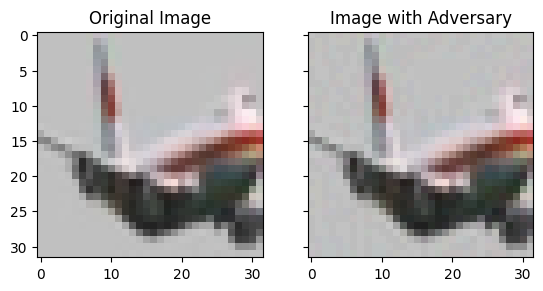

In [ ]:
from art.estimators.classification import KerasClassifier
# Comparing both images
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
print(f'Original Image Prediction: {label_names[model.predict(image).argmax()]}')
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
# Comparing predictions
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 30ms/step
Normal Image Prediction: airplane
1/1 [==============================] - 0s 36ms/step
Adversary Prediction: ship


In [ ]:
# Function to generate batch of images with adversary
def adversary_generator(batch_size):
  while True:
    images = []
    labels = []
    for batch in range(batch_size):
      N = randint(0, 49999)
      label = y_train[N]
      image = x_train[N].reshape((1,height, width, channels))

      perturbations = generate_adversary(image, label,0.2).numpy()
      adversarial = image + (perturbations * 0.2)

      images.append(adversarial)
      labels.append(label)

      if batch%1000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size, height, width, channels))
    labels = np.asarray(labels)

    yield images, labels

In [ ]:
# Testing model accuracy on adversarial examples
x_adversarial, y_adversarial = next(adversary_generator(10000))
ad_acc = model.evaluate(x_adversarial, y_adversarial, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")

0 images generated
1000 images generated
2000 images generated
3000 images generated
4000 images generated
5000 images generated
6000 images generated
7000 images generated
8000 images generated
9000 images generated
Accuracy on Adversarial Examples: 17.84999966621399


In [ ]:
import h5py
with h5py.File('adversarial_data_vgg.h5', 'w') as f:
    f.create_dataset('x_adversarial', data=x_adversarial)
    f.create_dataset('y_adversarial', data=y_adversarial)